<a href="https://colab.research.google.com/github/raz0208/Agritech-Pest-Prediction/blob/main/Agritech_Pest_Prediction_ARIMAX_TSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time Series Analysis For Agritech Pest Prediction

## Model Implementation:

## **ARIMAX**

In [39]:
# # Uninstall potentially conflicting versions first
# !pip uninstall -y pmdarima numpy

# # Install the latest NumPy 1.x version (e.g., 1.26.4)
# !pip install numpy==1.26.4

# # Now install pmdarima (hopefully it links against NumPy 1.26.4)
# # Use --no-cache-dir just to be safe
# !pip install --no-cache-dir pmdarima==2.0.4

In [40]:
# import required libaraies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [41]:
# Load datasets
FeatureExtracted_df = pd.read_csv('/content/FeatureExtracted_dataset.csv')

In [42]:
# Display basic info for  datasets FeatureExtracted_dataset
print(FeatureExtracted_df.head(), '\n')
print(FeatureExtracted_df.info())

         Date      Time  Number of Insects  New Catches  Event   Location  \
0  2024-07-06  06:01:00                0.0          0.0      0  Cicalino1   
1  2024-07-07  06:04:00                0.0          0.0      0  Cicalino1   
2  2024-07-08  06:03:00                0.0          0.0      0  Cicalino1   
3  2024-07-09  06:05:00                0.0          0.0      1  Cicalino1   
4  2024-07-10  06:03:00                0.0          0.0      0  Cicalino1   

   Average Temperature  Temp_low  Temp_high  Average Humidity  ...  \
0                13.91      13.6       14.4             97.65  ...   
1                20.78      20.1       21.2             83.49  ...   
2                19.03      18.7       19.5             96.87  ...   
3                15.33      15.0       15.7             82.29  ...   
4                15.48      15.0       16.0             87.12  ...   

   Day Max_temp  Day Avg_Humidity  Temp_change  Year  Month  Day  Weekday  \
0          30.6             72.25      

In [43]:
# Convert 'Date' column to datetime format
FeatureExtracted_df['Date'] = pd.to_datetime(FeatureExtracted_df['Date'])

In [44]:
# Drop some columns
FeatureExtracted_df.drop(['Lag_1', 'Lag_2', 'Lag_3'], axis=1, inplace=True)

# Group and aggregate
aggregated_df = FeatureExtracted_df.groupby('Date').agg({
    'Number of Insects': 'sum',
    'New Catches': 'sum',
    'Event': 'max',
    'Average Temperature': 'mean',
    'Temp_low': 'mean',
    'Temp_high': 'mean',
    'Average Humidity': 'mean',
    'Day Avg_temp': 'mean',
    'Day Min_temp': 'mean',
    'Day Max_temp': 'mean',
    'Day Avg_Humidity': 'mean',
    'Temp_change': 'mean',
    'Year': 'first',
    'Month': 'first',
    'Day': 'first',
    'Weekday': 'first',
    # 'Lag_1': 'mean',
    # 'Lag_2': 'mean',
    # 'Lag_3': 'mean'
}).reset_index()

print(aggregated_df.head(10))

# # save to csv file
# aggregated_df.to_csv('aggregated_dataset.csv', index=False)

        Date  Number of Insects  New Catches  Event  Average Temperature  \
0 2024-07-05                0.0          0.0      0              16.6900   
1 2024-07-06                0.0          0.0      0              16.5225   
2 2024-07-07                0.0          0.0      0              19.8125   
3 2024-07-08                0.0          0.0      1              17.7825   
4 2024-07-09                0.0          0.0      1              18.4850   
5 2024-07-10                0.0          0.0      0              15.4800   
6 2024-07-11                0.0          0.0      1              15.8400   
7 2024-07-12                0.0          0.0      0              16.6350   
8 2024-07-13                0.0          0.0      0              18.9650   
9 2024-07-14                1.0          1.0      0              17.1300   

   Temp_low  Temp_high  Average Humidity  Day Avg_temp  Day Min_temp  \
0    16.300     17.000           89.4800       27.1400        15.700   
1    16.175     16.

In [45]:
# Convert "Date" to datetime format
aggregated_df["Date"] = pd.to_datetime(aggregated_df["Date"])

# Set "Date" as the index
aggregated_df.set_index("Date", inplace=True)

# Check for Nan_Value
print(aggregated_df.isna().sum())

Number of Insects      0
New Catches            0
Event                  0
Average Temperature    0
Temp_low               0
Temp_high              0
Average Humidity       0
Day Avg_temp           0
Day Min_temp           0
Day Max_temp           0
Day Avg_Humidity       0
Temp_change            0
Year                   0
Month                  0
Day                    0
Weekday                0
dtype: int64


### Visualization trends

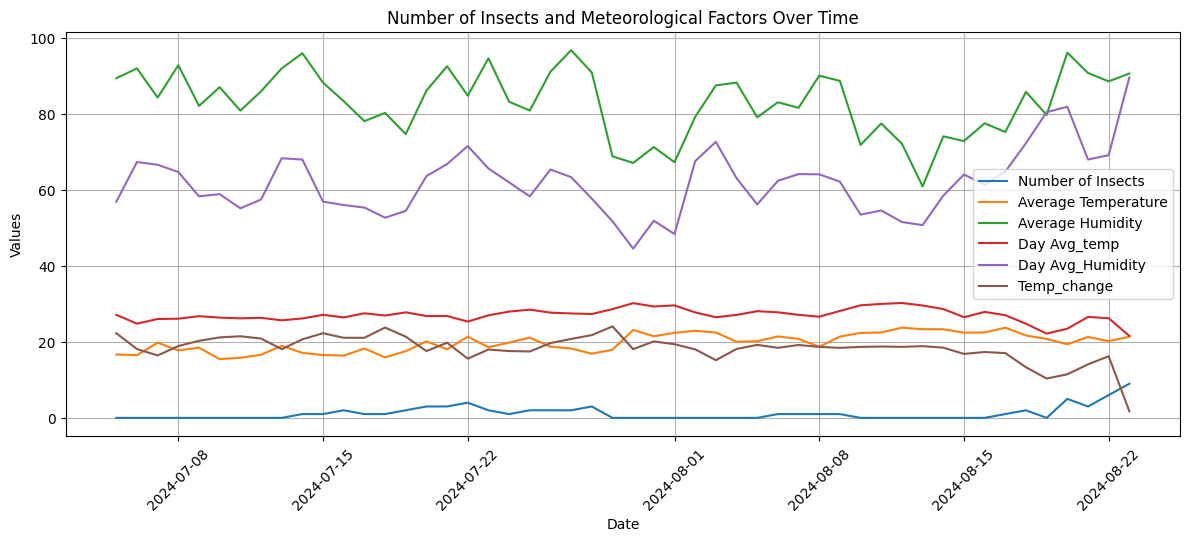

In [46]:
# Features to plot
features_to_plot = [
    'Number of Insects',
    'Average Temperature',
    'Average Humidity',
    'Day Avg_temp',
    'Day Avg_Humidity',
    'Temp_change'
]

# Plotting
plt.figure(figsize=(12, 5))
for feature in features_to_plot:
    plt.plot(aggregated_df.index, aggregated_df[feature], label=feature)

plt.title("Number of Insects and Meteorological Factors Over Time")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

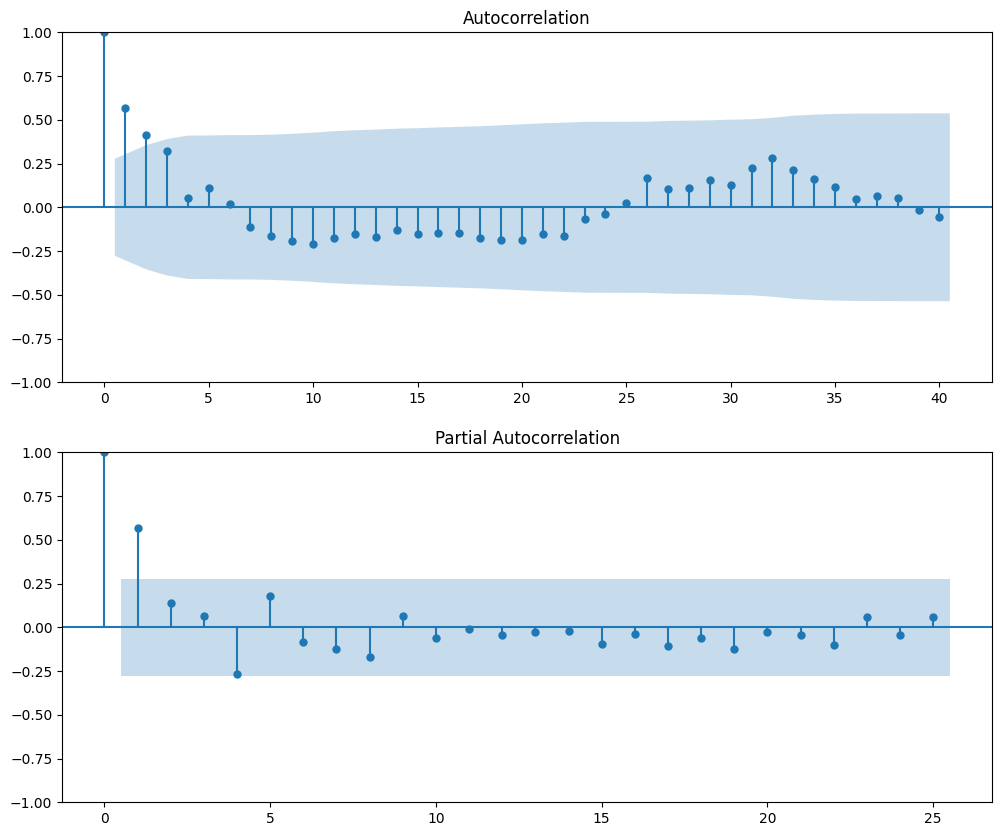

In [47]:
# Plot ACF and PACF to examine autocorrelation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(aggregated_df['Number of Insects'], lags=40, ax=ax1)
plot_pacf(aggregated_df['Number of Insects'], lags=25, ax=ax2)
plt.show()

### Check for Stationarity by Augmented Dickey-Fuller (ADF Test)

In [48]:
# Perform Augmented Dickey-Fuller (ADF) test to check for stationarity
def check_stationarity(series):
    """
    Performs the Augmented Dickey-Fuller (ADF) test to check for stationarity.

    Parameters:
        series (pd.Series): Time series data (e.g., insect count indexed by date).

    Returns:
        dict: Contains ADF statistic, p-value, critical values, and interpretation.
    """
    adf_result = adfuller(series.dropna())

    result = {
        "ADF Statistic": adf_result[0],
        "p-value": adf_result[1],
        "# Lags Used": adf_result[2],
        "# Observations": adf_result[3],
        "Critical Values": adf_result[4]
    }

    # Interpretation
    result["Stationary"] = adf_result[1] < 0.05

    print("ADF Statistic:", result["ADF Statistic"])
    print("p-value:", result["p-value"])
    print("# Lags Used:", result["# Lags Used"])
    print("# Observations:", result["# Observations"])
    print("Critical Values:")
    for key, value in result["Critical Values"].items():
        print(f"   {key}: {value}")

    if result["Stationary"]:
        print("✅ Series is stationary (p < 0.05)")
    else:
        print("⚠️ Series is not stationary (p >= 0.05)")

    #return result

check_stationarity(aggregated_df['Number of Insects'])

ADF Statistic: -1.7530607202128317
p-value: 0.4040019312158851
# Lags Used: 7
# Observations: 42
Critical Values:
   1%: -3.596635636000432
   5%: -2.933297331821618
   10%: -2.6049909750566895
⚠️ Series is not stationary (p >= 0.05)


### Apply Differencing (if needed) and check Stationarity

In [49]:
# ##--- ### Method 1 to make stationary ### ---##

# # Make stationary function
# def make_stationary(series, max_diff=100, verbose=True):
#     """
#     Automatically differences a series until it becomes stationary (ADF p-value <= 0.05).

#     Parameters:
#         series (pd.Series): The time series to make stationary
#         max_diff (int): Maximum differencing order to try
#         verbose (bool): Whether to print ADF results

#     Returns:
#         stationary_series (pd.Series): Differenced series
#         d (int): The order of differencing applied
#     """
#     for d in range(max_diff + 1):
#         if d > 0:
#             differenced = series.diff(d).dropna()
#         else:
#             differenced = series.dropna()

#         result = adfuller(differenced, autolag='AIC')
#         p_value = result[1]

#         if verbose:
#             print(f'Differencing Order: {d}, ADF p-value: {p_value}')

#         if p_value <= 0.05:
#             if verbose:
#                 print(f"✅ Series is stationary with differencing order d={d}\n")
#             return differenced, d

#     print("⚠️ Series is still not stationary after maximum differencing.")
#     return differenced, max_diff

# # Call function
# df_diff, num_diffs = make_stationary(DateAgg_df['Number of Insects'])

In [50]:
# # Plot differenced data
# plt.figure(figsize=(14, 5))
# plt.plot(df_diff, marker='o', linestyle='-')
# plt.title(f'Differenced Insect Count (Differencing {num_diffs})')
# plt.xlabel('Date')
# plt.ylabel('Differenced Value')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [51]:
##--- ### Method 2 to make stationary ### ---##

# Function to apply Differencing and check Stationarity
def make_stationary(ts, max_diff=6, verbose=True):
    d = 0
    result = adfuller(ts.dropna())
    if verbose:
        print(f"ADF Test p-value (d={d}): {result[1]:.4f}")
    while result[1] > 0.05 and d < max_diff:
        ts = ts.diff().dropna()
        d += 1
        result = adfuller(ts)
        if verbose:
            print(f"ADF Test p-value (d={d}): {result[1]:.4f}")
    if verbose and result[1] <= 0.05:
        print(f"✅ Series is stationary at d={d}")
    return ts, d

# Call the function
df_diff, num_diffs = make_stationary(aggregated_df['Number of Insects'])

ADF Test p-value (d=0): 0.4040
ADF Test p-value (d=1): 0.8930
ADF Test p-value (d=2): 0.1556
ADF Test p-value (d=3): 0.0000
✅ Series is stationary at d=3


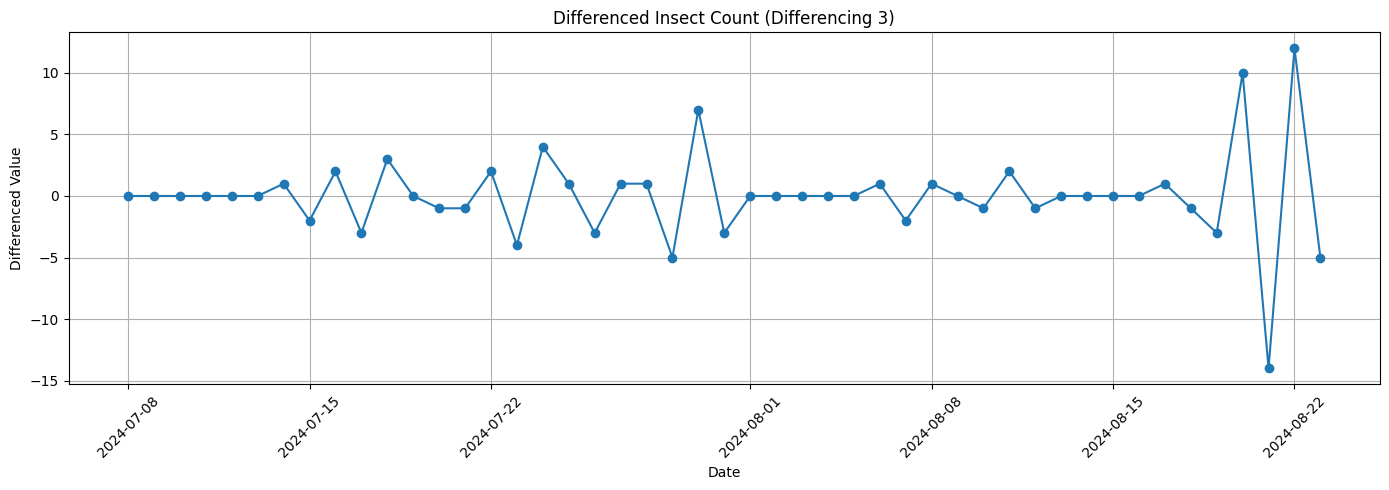

In [52]:
# Plot differenced data
plt.figure(figsize=(14, 5))
plt.plot(df_diff, marker='o', linestyle='-')
plt.grid(True)
plt.title(f'Differenced Insect Count (Differencing {num_diffs})')
plt.xlabel('Date')
plt.ylabel('Differenced Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [53]:
# Choose meteorological features for ARIMAX
exog_features = [
    'New Catches',
    'Event',
    'Average Temperature',
    'Temp_low',
    'Temp_high',
    'Average Humidity',
    'Day Min_temp',
    'Day Max_temp',
    'Day Avg_temp',
    'Day Avg_Humidity',
    'Temp_change',
    # 'Year',
    # 'Month',
    # 'Day',
    # 'Weekday'
]

exogenous_data = aggregated_df[exog_features]

# Optional: Check for NaNs in exogenous data
print("\nMissing values in exogenous features:\n")
print(exogenous_data.isnull().sum())


Missing values in exogenous features:

New Catches            0
Event                  0
Average Temperature    0
Temp_low               0
Temp_high              0
Average Humidity       0
Day Min_temp           0
Day Max_temp           0
Day Avg_temp           0
Day Avg_Humidity       0
Temp_change            0
dtype: int64


In [54]:
# Make target stationary and determine best differencing order
target_series = aggregated_df['Number of Insects']

# # Drop initial rows to align target and exogenous data after differencing
# aligned_exog = exogenous_data.iloc[num_diffs:]

# Use auto_arima to find best ARIMAX configuration
arimax_model = auto_arima(
    y=target_series,  # Use original series, auto_arima will apply differencing internally
    exogenous=exogenous_data,
    seasonal=False,
    d=num_diffs,  # Let auto_arima determine differencing
    #max_d=2,
    start_p=1,
    start_q=1,
    max_p=5,
    max_q=5,
    stepwise=True,
    trace=True,
    suppress_warnings=True,
    error_action='ignore'
)

# Model summary
print(arimax_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=258.696, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=212.523, Time=0.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,3,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=183.814, Time=0.04 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=179.902, Time=0.04 sec
 ARIMA(4,3,0)(0,0,0)[0]             : AIC=181.328, Time=0.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,3,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,3,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(3,3,0)(0,0,0)[0] intercept   : AIC=181.854, Time=0.06 sec

Best model:  ARIMA(3,3,0)(0,0,0)[0]          
Total fit time: 1.044 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   50
Model:               SARIMAX(3, 3, 0)   Log Likelihood                 -85.951
Date:                Tue, 08 Apr 2025   AIC                            179.902
Time:                        14:26:39   BIC                            187.302
Sample:                    07-05-2024   HQIC                           182.687
                         - 08-23-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1  

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


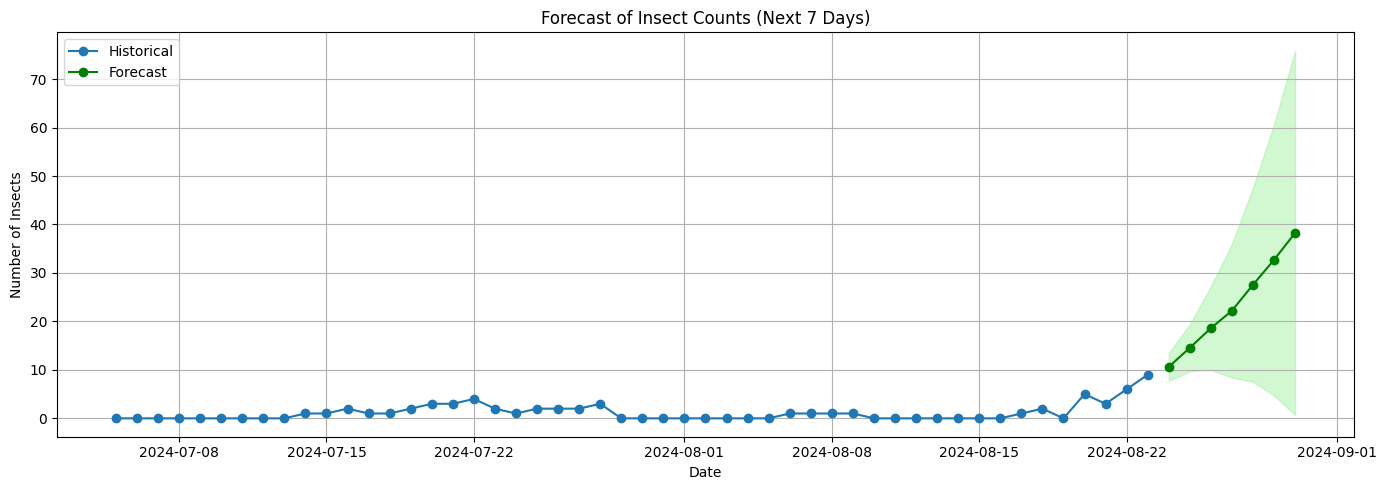

In [58]:
from datetime import timedelta

# Forecasting next X days
n_periods = 7

# Create future exogenous variables for 7 days (this is essential!)
future_exog = exogenous_data[:n_periods]  # <-- Replace with your actual future exog

# Forecast with confidence intervals
forecast, conf_int = arimax_model.predict(n_periods=n_periods, exogenous=future_exog, return_conf_int=True)

# Create forecast index
last_date = aggregated_df.index[-1]
forecast_index = pd.date_range(start=last_date + timedelta(days=1), periods=n_periods, freq='D')

# Build forecast DataFrame
forecast_df = pd.DataFrame({
    'Forecast': forecast,
    'Lower_CI': conf_int[:, 0],
    'Upper_CI': conf_int[:, 1]
}, index=forecast_index)

# Plotting
plt.figure(figsize=(14, 5))
plt.plot(aggregated_df.index, aggregated_df['Number of Insects'], label='Historical', marker='o')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='green', marker='o')
plt.fill_between(forecast_df.index, forecast_df['Lower_CI'], forecast_df['Upper_CI'], color='lightgreen', alpha=0.4)
plt.title('Forecast of Insect Counts (Next 7 Days)')
plt.xlabel('Date')
plt.ylabel('Number of Insects')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()